In [1]:
import keras
from keras.api.models import Model, load_model
from keras.api.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.src.backend.common.keras_tensor import KerasTensor
from keras.api.optimizers import Adam
from keras.api.layers import Concatenate
from keras.api.losses import binary_focal_crossentropy
import glob
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
SIZE = 256
keras.backend.backend()

'torch'

# Unet Architecture

In [3]:
def convolution_block(previous_layer: KerasTensor, filters_n: int):
	convolution1 = Conv2D(filters_n, 3, activation='relu', padding='same')(previous_layer)
	convolution2 = Conv2D(filters_n, 3, activation='relu', padding='same')(convolution1)
	return convolution2

def encoder_block(previous_layer: KerasTensor, filters_n: int):
	conv = convolution_block(previous_layer, filters_n)
	pool = MaxPooling2D(pool_size=(2, 2))(conv)
	return pool, conv

def decoder_block(previous_layer: KerasTensor, skip_layer: KerasTensor, filters_n: int):
	upscale = Conv2DTranspose(filters_n, (2, 2), strides=2, padding='same')(previous_layer)
	concat = Concatenate()([upscale, skip_layer])
	conv = convolution_block(concat, filters_n)
	return conv

def create_model():
	inputs = Input((SIZE, SIZE, 3))
	encoder1, conv1 = encoder_block(inputs, 64)
	encoder2, conv2 = encoder_block(encoder1, 128)
	encoder3, conv3 = encoder_block(encoder2, 256)
	encoder4, conv4 = encoder_block(encoder3, 512)
	
	bridge = convolution_block(encoder4, 1024)
	
	decoder1 = decoder_block(bridge, conv4, 512)
	decoder2 = decoder_block(decoder1, conv3, 256)
	decoder3 = decoder_block(decoder2, conv2, 128)
	decoder4 = decoder_block(decoder3, conv1, 64)
	
	output = Conv2D(1, 1, activation='sigmoid', padding='same')(decoder4)
	
	return Model(inputs=inputs, outputs=output)

model = create_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

# Compile Model
- I utilized `binary_focal_crossentropy` as the loss function due to the rarity of the target class and the presence of class imbalance.
- The appropriate metric for this task is Intersection over Union (IoU).
- However, I opted not to use IoU because it would considerably slow down the training process.

In [4]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=binary_focal_crossentropy, metrics=['accuracy'])

# Load Data

In [5]:
train_image_paths = sorted(glob.glob('dataset/train/*.png'))
train_masks_paths = sorted(glob.glob('dataset/trainannot/*.png'))
validation_image_paths = sorted(glob.glob('dataset/val/*.png'))
validation_masks_paths = sorted(glob.glob('dataset/valannot/*.png'))

In [6]:
train_fraction = .8

def load_images(image_paths: list[str], size=256) -> np.ndarray:
	images_data = np.array([cv2.resize(cv2.imread(image_path)[:,:,::-1], (size, size)) for image_path in image_paths])
	images_data = images_data / 255
	return images_data

def load_masks(mask_paths: list[str], size=256) -> np.ndarray:
	masks_data = np.array([cv2.resize(cv2.imread(mask_path)[:,:,0], (size, size)) for mask_path in mask_paths])
	masks_data = np.where(masks_data==2, 0, 1)
	return masks_data

images = load_images(train_image_paths, SIZE)
masks = load_masks(train_masks_paths, SIZE)

train_images = images[:int(len(masks)*train_fraction)]
train_masks = masks[:int(len(masks)*train_fraction)]
validation_images = images[int(len(masks)*train_fraction):]
validation_masks = masks[int(len(masks)*train_fraction):]

In [7]:
history = model.fit(train_images, train_masks, batch_size=9, epochs=100, validation_split=0.2)

Epoch 1/100


/usr/local/lib/python3.12/site-packages/keras/src/backend/torch/nn.py:402: UserWarning: Attempt to open cnn_infer failed: handle=0 error: libcudnn_cnn_infer.so.8: cannot open shared object file: No such file or directory (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:78.)
  outputs = tnn.conv2d(


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 655ms/step - accuracy: 0.9009 - loss: 0.0845 - val_accuracy: 0.9894 - val_loss: 0.0313
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 663ms/step - accuracy: 0.9894 - loss: 0.0253 - val_accuracy: 0.9894 - val_loss: 0.0196
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 685ms/step - accuracy: 0.9882 - loss: 0.0196 - val_accuracy: 0.9894 - val_loss: 0.0160
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 654ms/step - accuracy: 0.9891 - loss: 0.0163 - val_accuracy: 0.9894 - val_loss: 0.0166
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 654ms/step - accuracy: 0.9871 - loss: 0.0198 - val_accuracy: 0.9894 - val_loss: 0.0167
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 654ms/step - accuracy: 0.9893 - loss: 0.0157 - val_accuracy: 0.9894 - val_loss: 0.0159
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 649ms/step - accuracy: 0.9888 - loss: 0.0157 - val_accuracy: 0.9894 - val_loss: 0.0171
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 648ms/step - accuracy: 0.9884 - loss: 0.0167 - val_accuracy: 0.9894

<Axes: >

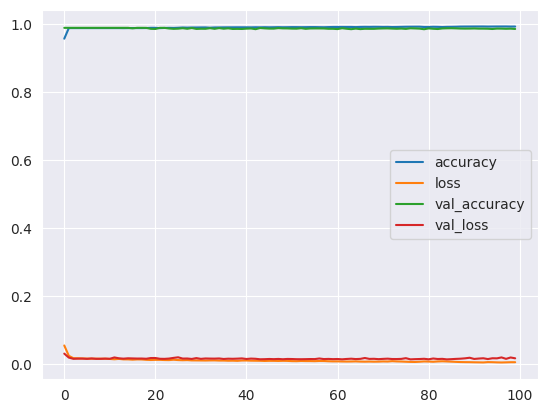

In [8]:
pd.DataFrame(history.history).plot()

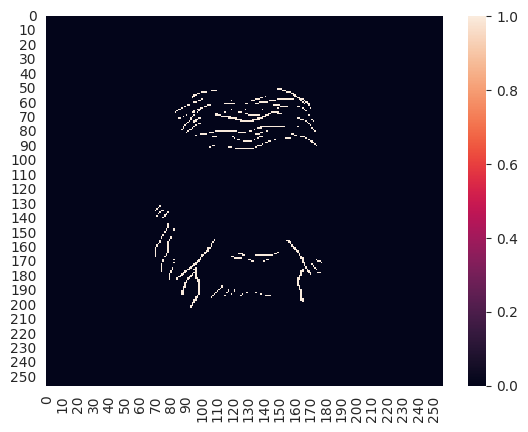

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


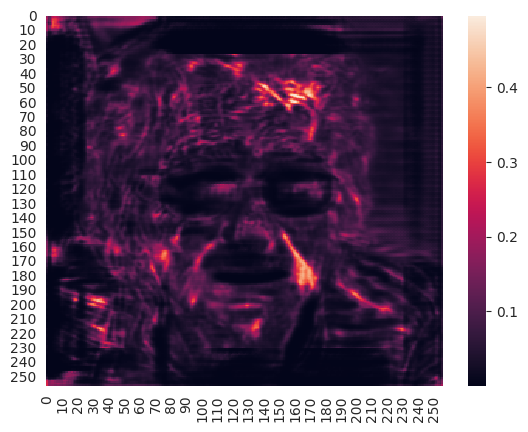

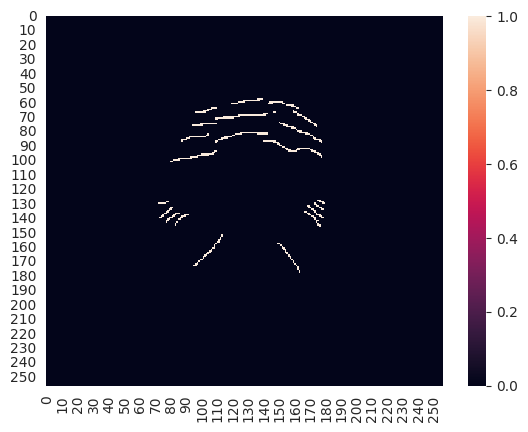

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


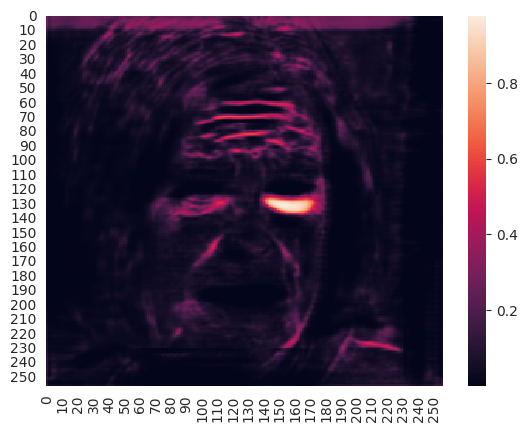

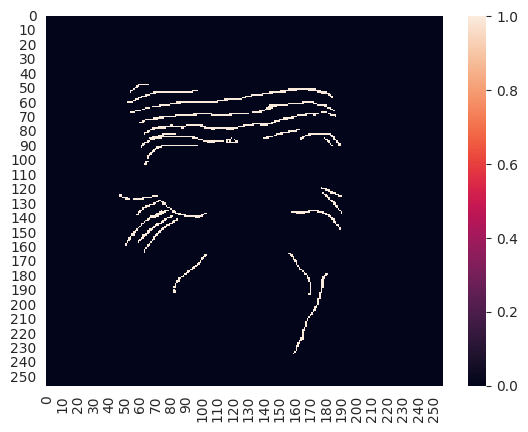

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


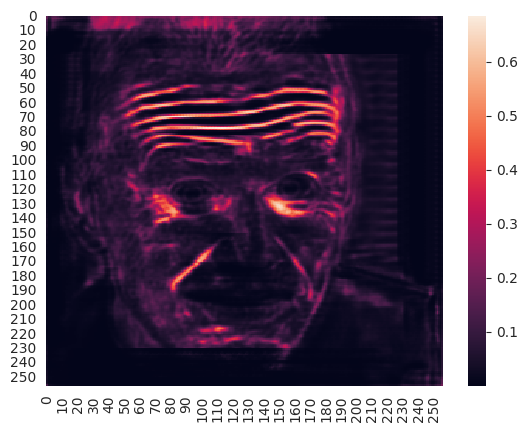

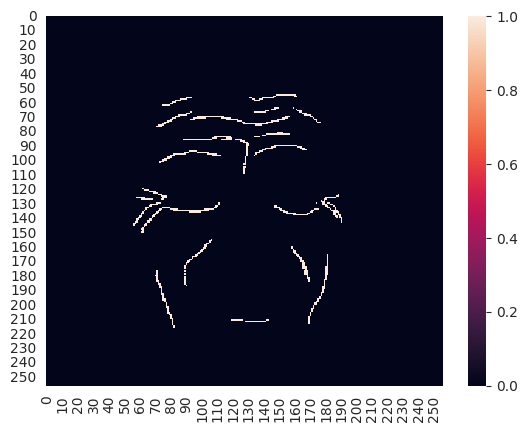

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


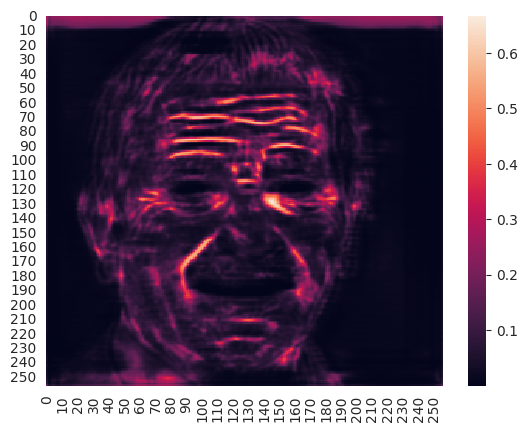

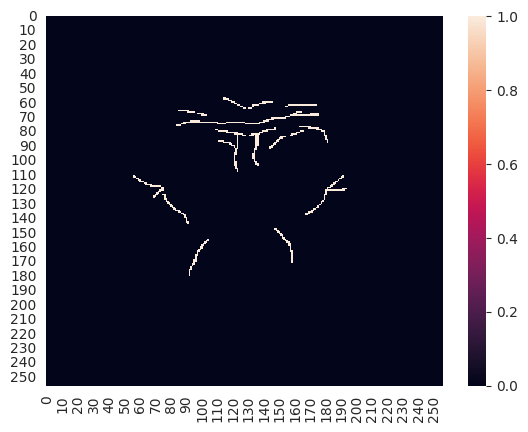

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


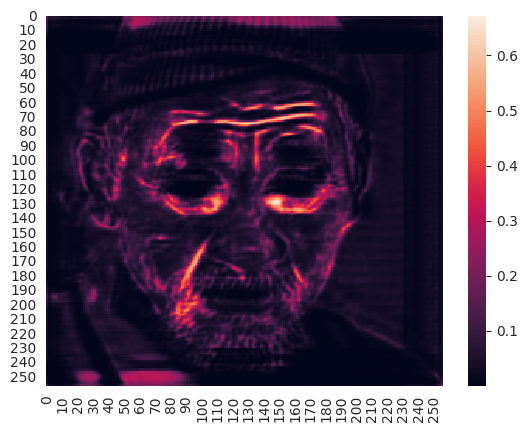

In [9]:
for i in range(len(validation_masks[:5])):
	sns.heatmap(validation_masks[i])
	plt.show()
	sns.heatmap(model.predict(validation_images[i:i+1])[0, :, :, 0])
	plt.show()